## Movies Reviews Text Based Analysis & Classification Project
ADS509 - Team 3 - Final Group Project<p>
Jacqueline Vo, Connie Chow<p>
October 23, 2023

### Load the Movie Reviews Data

In [4]:
# Data Manipulation and Analysis
import pandas as pd

# Text Preprocessing and NLP
import emoji
import nltk
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation

# Text Feature Extraction and NLP Models
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

# ML Models and Tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# Topic Modeling
#import pyLDAvis.lda_model
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD, LatentDirichletAllocation

# Additional Libraries
from collections import Counter

# Install packages if needed
#spacy.cli.download('en_core_web_sm')
#nlp = spacy.load('en_core_web_sm')

In [5]:
# Define the URL
url = "https://raw.githubusercontent.com/jvo024/ads509-movie-scrape/main/datasets/all_tmbd_rt_data.csv"

# Read data from the URL into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame (optional)
df.head()

,movie_title,review_rating,review_content,sentiment
0,Blue Beetle,7.0,MORE SPOILER-FREE MINI-REVIEWS @ https://www.m...,good
1,Blue Beetle,6.0,"Maybe this should just have been called the ""B...",good
2,Blue Beetle,7.0,Blue beetle is very awesome!! WoW!👏🏻👏🏻👍🏻👍🏻,good
3,Blue Beetle,6.0,The Good: Light-hearted and family centric. Lo...,good
4,Meg 2: The Trench,5.0,"Now the ""Meg"" (2018) itself could never be cal...",good


### Text Data Preprocessing

In [6]:
from nltk.corpus import stopwords
from collections import Counter

PUNCTUATION = set(punctuation)
STOPWORDS = set(stopwords.words("english"))

def descriptive_stats(tokens, top_tokens=10, verbose=True):
    """
    Calculate descriptive statistics for a list of tokens.
    Args:
        tokens (list): List of tokens.
        top_tokens (int): Number of top tokens to display.
        verbose (bool): Print statistics if True.
    Returns:
        list: A list containing [num_tokens, num_unique_tokens, lexical_diversity, num_characters]
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = sum(len(token) for token in tokens)
    token_counter = Counter(tokens)
    most_common_tokens = token_counter.most_common(top_tokens)

    if verbose:
        print(f"Number of tokens: {num_tokens}")
        print(f"Number of unique tokens: {num_unique_tokens}")
        print(f"Number of characters: {num_characters}")
        print(f"Lexical diversity: {lexical_diversity:.3f}")
        print(f"Most common tokens (Top {top_tokens}):")
        for token, count in most_common_tokens:
            print(f" - {token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

def remove_hyperlink(text):
    """
    Remove hyperlinks from text using regular expressions.
    """
    hyperlink_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    cleaned_text = re.sub(hyperlink_pattern, '', text)
    return cleaned_text

def remove_stop(tokens):
    """
    Remove stopwords from a list of tokens.
    """
    removed_tokens = [token for token in tokens if token.lower() not in STOPWORDS and token != 'nan']
    return removed_tokens

def remove_numerical(tokens):
    """
    Remove tokens that are purely numerical.
    """
    cleaned_tokens = [token for token in tokens if not re.match(r'^[0-9.]+$', token)]
    return cleaned_tokens

def remove_punctuation(text):
    """
    Remove punctuation from text.
    """
    if text == 'nan':
        return ''  # Remove 'nan'

    PUNCTUATION.add("'")
    return "".join([ch for ch in text if ch not in PUNCTUATION])

def tokenize(text):
    """
    Tokenize text.
    """
    return word_tokenize(text)

def prepare(text, pipeline):
    """
    Apply a list of text processing transformations to a text.
    """
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


whitespace_pattern = re.compile(r"\s+")
all_language_emojis = set()

for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)


In [7]:
pipeline = [remove_hyperlink, str.lower, remove_punctuation, tokenize, remove_stop, remove_numerical]

df["tokens"] = df["review_content"].apply(prepare, pipeline=pipeline)
df["num_tokens"] = df["tokens"].map(len)
df.sample(n=5)

,movie_title,review_rating,review_content,sentiment,tokens,num_tokens
708,The Lion King,10.0,"If you enjoy reading my reviews, please follow...",good,"[enjoy, reading, reviews, please, follow, blog...",584
8580,Argo,NaN,The film goes out on a high with a third act t...,good,"[film, goes, high, third, act, never, lets, te...",24
7541,On Her Majesty's Secret Service,2.0,This was the worst Bond movie of the early era...,bad,"[worst, bond, movie, early, era, nothing, laze...",84
4373,Crazy Rich Asians,7.0,**Crazy Rich Asians doesn’t reinvent the rom-c...,good,"[crazy, rich, asians, ’, reinvent, romcom, for...",73
8502,Moonlight,NaN,Gorgeous to look at and accompanied by an exqu...,good,"[gorgeous, look, accompanied, exquisite, sound...",5


<div class="alert alert-block alert-info">
A pipeline was applied to remove hyperlinks, punctuation, stopwords, numbers, in addition to converting all words into lowercase, and tokenizing review_content. For additional analysis, the total number of tokens were counted for each movie review given.
</div>

### Exploratory Data Analysis

#### Descriptive Statistics for Good and Bad Reviews

In [8]:
# Pre-processing split to view dataset in good/bad
good_df = df[df['sentiment'] == 'good']
bad_df = df[df['sentiment'] == 'bad']

# Combine all tokens
good_tokens = good_df["tokens"].sum()
bad_tokens = bad_df["tokens"].sum()

In [9]:
# Use descriptive stats function on both datasets
print(f"--- Good Reviews ---")
good_stats = descriptive_stats(good_tokens)
print(f"--- Bad Reviews ---")
bad_stats = descriptive_stats(bad_tokens)

--- Good Reviews ---
Number of tokens: 872782
Number of unique tokens: 49752
Number of characters: 5303945
Lexical diversity: 0.057
Most common tokens (Top 10):
 - film: 10464
 - movie: 8814
 - ’: 7549
 - one: 6790
 - like: 4857
 - story: 4770
 - good: 4330
 - well: 3836
 - really: 3708
 - time: 3544
--- Bad Reviews ---
Number of tokens: 132379
Number of unique tokens: 18338
Number of characters: 792191
Lexical diversity: 0.139
Most common tokens (Top 10):
 - movie: 1830
 - film: 1563
 - ’: 1427
 - one: 1046
 - like: 1030
 - even: 745
 - good: 695
 - really: 606
 - story: 565
 - much: 546


<div class="alert alert-block alert-info">
Just to note, we are aware of the apostrophe showing up as a top token.  After some research, we concluded that the tokenization needs to be done using spacy package which can process contraction words.  For example, a token like "I'm" can be broken up into I and am.  This was one step further that will be explored with the project Next Steps.
</div>

#### Token Concentration

In [10]:
from collections import Counter

# Count total number of tokens for both dataframes
total_good = good_stats[0]
total_bad = bad_stats[0]

token_counts_good = Counter(good_tokens)
token_counts_bad = Counter(bad_tokens)

# Create dataframe to label the token, and number of times it appears for both good/bad
good_df = pd.DataFrame(token_counts_good.items(), columns=["token", "good_tokens"])
bad_df = pd.DataFrame(token_counts_bad.items(), columns=["token", "bad_tokens"])

# Calculate the concentration for good/bad tokens
good_df["good concentration"] = good_df.apply(lambda row: row["good_tokens"] / total_good, axis=1)
bad_df["bad concentration"] = bad_df.apply(lambda row: row["bad_tokens"] / total_bad, axis=1)

calc_df = [good_df, bad_df]

group_df = calc_df[0]


for calc_df in calc_df[1:]:

    group_df = pd.merge(group_df, calc_df, on="token", how="inner")

cutoff = 5

def check_cutoff(row):
    """
    Verify that this token appears in good_df and bad_df above the specified cut-off
    """
    return (row['good_tokens'] > cutoff) and (row['bad_tokens'] > cutoff)

group_df['cutoff'] = group_df.apply(check_cutoff, axis=1)
group_df['ratio'] = group_df["good_tokens"] / group_df["bad_tokens"]

In [11]:
# Identify tokens with largest ratio of good:bad
top_10 = group_df[group_df['cutoff'] == True].sort_values(by='ratio', ascending=False).head(10)
top_10

,token,good_tokens,good concentration,bad_tokens,bad concentration,cutoff,ratio
1014,wonderful,329,0.000377,7,0.000053,True,47.000000
983,emotionally,233,0.000267,6,0.000045,True,38.833333
1980,bill,192,0.000220,7,0.000053,True,27.428571
754,superb,266,0.000305,10,0.000076,True,26.600000
2236,terrific,186,0.000213,7,0.000053,True,26.571429
1888,ride,205,0.000235,8,0.000060,True,25.625000
71,b,425,0.000487,17,0.000128,True,25.000000
973,nicely,163,0.000187,7,0.000053,True,23.285714
982,excellent,802,0.000919,35,0.000264,True,22.914286
5065,magnificent,135,0.000155,6,0.000045,True,22.500000


In [12]:
# Identify tokens with smallest ratio of good:bad
bottom_10 = group_df[group_df['cutoff'] == True].sort_values(by='ratio', ascending=False).tail(10)
bottom_10

,token,good_tokens,good concentration,bad_tokens,bad concentration,cutoff,ratio
8397,miserably,8,0.000009,11,0.000083,True,0.727273
12526,stinks,6,0.000007,9,0.000068,True,0.666667
9706,junk,6,0.000007,9,0.000068,True,0.666667
2230,redeeming,16,0.000018,25,0.000189,True,0.640000
10381,caleb,7,0.000008,12,0.000091,True,0.583333
7692,grudge,6,0.000007,11,0.000083,True,0.545455
11528,guadagnino,6,0.000007,13,0.000098,True,0.461538
2464,unfunny,6,0.000007,13,0.000098,True,0.461538
7902,finished,42,0.000048,94,0.000710,True,0.446809
4524,steppenwolf,10,0.000011,24,0.000181,True,0.416667


<div class="alert alert-block alert-info">
We explored if certain tokens were more common based on the sentiment of the review. A cutoff was set so that this token would need to appear more times than the specified cut-off. In this case, it would need to appear in good_tokens and bad_tokens greater than 5 times. It appears that there are clear positive and negative connotations for certain tokens, however there are also tokens that might seem out of context such as caleb, guadgnino, and steppewolf.
</div>

#### Word Clouds: Tokens from Bad Reviews Word Cloud & Good Review Word Cloud

In [13]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def count_words(df, column='token', preprocess=None, min_freq=2):
    """"
    Process tokens and update counter
    """
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

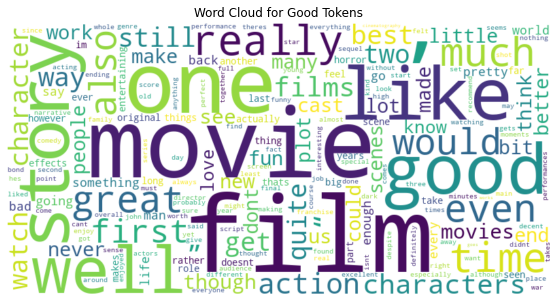

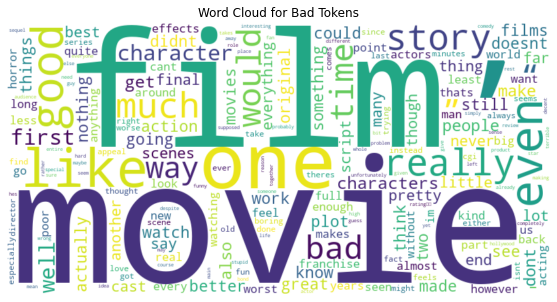

In [14]:
def generate_wordcloud(tokens, title, width=800, height=400, background_color="white"):

    wordcloud = WordCloud(width=width, height=height, background_color=background_color).generate_from_frequencies(tokens)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


# Create word clouds for good_tokens and bad_tokens
good_word_counts = Counter(good_tokens)
bad_word_counts = Counter(bad_tokens)

generate_wordcloud(good_word_counts, "Word Cloud for Good Tokens")
generate_wordcloud(bad_word_counts, "Word Cloud for Bad Tokens")

<div class="alert alert-block alert-info"> Both the good and bad sentiment wordclouds appear fairly generic in terms of most frequent words. There are no extremely polarizing tokens that might outwardly indicate a specific sentiment on its own. </div>

#### Most Common Two Word Phrases for Good Review

C:\Users\Connie\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


<AxesSubplot:title={'center':'Bigrams Frequency - Most Common Two Word Phrases in Good Reviews'}, xlabel='Bigram Words', ylabel='Count'>

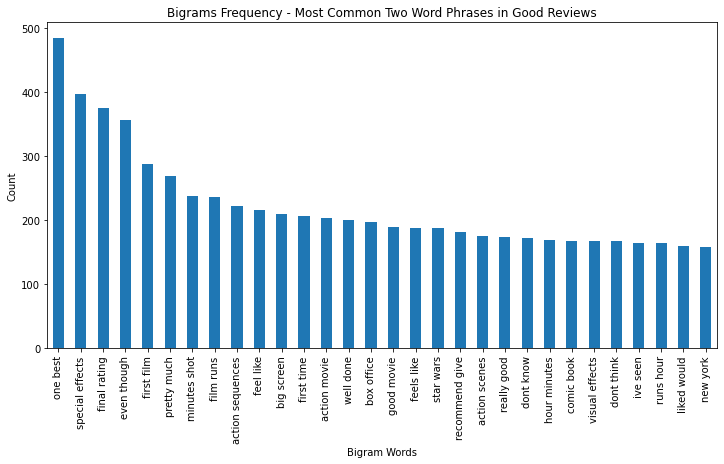

In [52]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get preprocessed tokens as string
df_good_reviews = df[df['sentiment']=='good']
df_good_reviews['combined_tokens'] = df_good_reviews['tokens'].apply(lambda token_list: ' '.join(token_list))
common_words = get_top_n_bigram(df_good_reviews['combined_tokens'], 30)
df2 = pd.DataFrame(common_words, columns=['Text', "Count"])

df2.groupby('Text').sum()['Count'].sort_values(ascending=False).plot(
kind='bar',
figsize=(12,6),
xlabel = "Bigram Words",
ylabel = "Count",
title = "Bigrams Frequency - Most Common Two Word Phrases in Good Reviews"
)

<div class="alert alert-block alert-info">Good Reviews most commonly had two word phrases such as "special effects", "action sequences", "big screen", "action movie", "star wars", "action scenes", and "visual effects".  These phrases point to the action or adventure genre of movies.  It could be said that typially good reviews tended to be associated with action films.</div>

#### Most Common Two Word Phrases for Bad Review

C:\Users\Connie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:title={'center':'Bigrams Frequency - Most Common Two Word Phrases in Bad Reviews'}, xlabel='Bigram Words', ylabel='Count'>

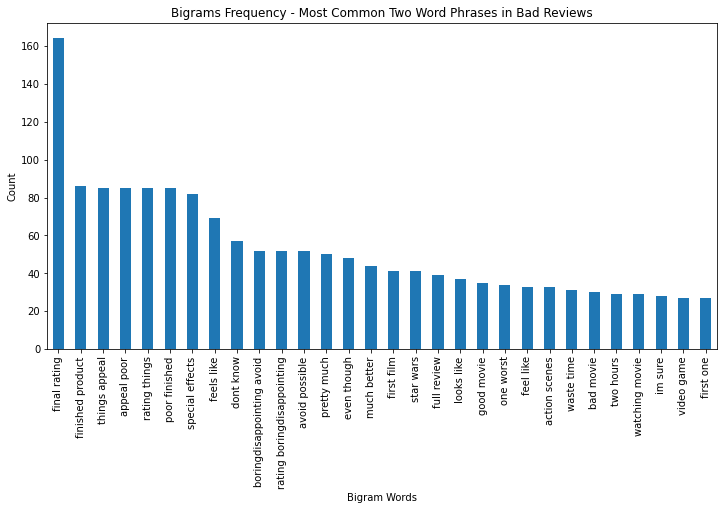

In [53]:
# Get preprocessed tokens as string
df_bad_reviews = df[df['sentiment']=='bad']
df_bad_reviews['combined_tokens'] = df_bad_reviews['tokens'].apply(lambda token_list: ' '.join(token_list))
common_words = get_top_n_bigram(df_bad_reviews['combined_tokens'], 30)
df2 = pd.DataFrame(common_words, columns=['Text', "Count"])

df2.groupby('Text').sum()['Count'].sort_values(ascending=False).plot(
kind='bar',
figsize=(12,6),
xlabel = "Bigram Words",
ylabel = "Count",
title = "Bigrams Frequency - Most Common Two Word Phrases in Bad Reviews"
)

<div class="alert alert-block alert-info"> Bad reviews tended to not have as many action related phrases like with the good reviews.  Rather bad reviews centered around two word phrases such as "appeal poor", "poor finished", "boring disappointing avoid", "avoid possible".  This leads to the conclusion that bad reviews tended to be any movie which reviewers regarded as boring, disappointing, or poor in quality and to avoid altogether.  It was not associated with any particular genre like with good reviews. </div>

### Train Test Split Dataset

In [16]:
movie_reviews = df[['tokens', 'sentiment']].values.tolist()

In [17]:
word_cutoff = 10

tokens = [word for text, _ in movie_reviews for word in text]

word_dist = nltk.FreqDist(tokens)

feature_words = set()

for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 10, we have 9723 as features in the model.


In [18]:
def conv_features(text,fw) :
    """This function takes in the movie review text and list of
    feature words (from above) and marks each word in the review
    as either existing in the feature word list as True or False
    This will be fed as training data to the classifier
    """

    ret_dict = dict()

    words = text.split()
   
    # Iterate through the words in the text
    for word in words:
        # Check if the word is in the list of words fw
        if word in fw:
            # If it is in fw, set its value to True in the features dictionary
            ret_dict[word] = True
            
    return {k: v for k, v in ret_dict.items() if v}
    
    return(ret_dict)

In [19]:
featuresets = [(conv_features(' '.join(tokens), feature_words), sentiment)
               for (tokens, sentiment) in movie_reviews]

<div class="alert alert-block alert-info"> The features here will be used for the upcoming modeling phase. This will create a list of lists, where each list is a review with a list of tokens, in addition to the sentiment of the review. </div>

### Modeling & Evaluation

#### Naive Bayes Model

<div class="alert alert-block alert-info"> [Naive Bayes is the classification model typically used for text based analysis and sentiment analysis.  It is a quick algorithm and can pickup the feature set even with a small a dataset.  It also assumes independence between feature words, allowing each token to have equal weight] </div>

In [20]:
test_size = 500
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Accuracy Score: ", nltk.classify.accuracy(classifier, test_set))

Accuracy Score:  0.88


In [21]:
# Get the most informative features (tokens)
classifier.show_most_informative_features(25)

Most Informative Features
                 dumbest = True              bad : good   =     18.3 : 1.0
                 unfunny = True              bad : good   =     15.5 : 1.0
             wonderfully = True             good : bad    =     14.9 : 1.0
                simpsons = True              bad : good   =     13.0 : 1.0
                   velma = True              bad : good   =     13.0 : 1.0
               homicidal = True              bad : good   =     12.2 : 1.0
                finished = True              bad : good   =     12.1 : 1.0
              amateurish = True              bad : good   =     10.6 : 1.0
                 hercule = True              bad : good   =     10.0 : 1.0
                  drivel = True              bad : good   =      9.3 : 1.0
                   pills = True              bad : good   =      9.3 : 1.0
              denouement = True             good : bad    =      9.2 : 1.0
                    quit = True              bad : good   =      8.7 : 1.0

#### LinearSVC Model

<div class="alert alert-block alert-info"> [SVM generalizes well in high dimensional spaces like those corresponding to texts.  This algorithm eliminates the need for feature selection which makes its application to text analysis much easier.] </div>

In [22]:
from sklearn.metrics import accuracy_score

X = df['review_content']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

freq_vector = CountVectorizer(stop_words="english")
X_train_freq = freq_vector.fit_transform(X_train)
X_train_freq.shape

tfidf_transf = TfidfTransformer()
X_train_tfidf = tfidf_transf.fit_transform(X_train_freq)
X_train_tfidf.shape

svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

X_test_freq = freq_vector.transform(X_test)
X_test_tfidf = tfidf_transf.transform(X_test_freq)
y_pred = svc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8934331797235023


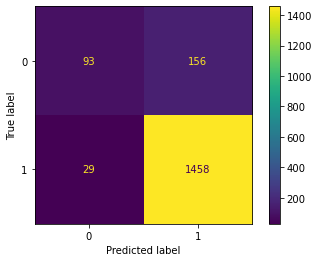

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

#### Random Forest Classifier Model

In [24]:
# # Transform the Input Text of Training Data using Trained Tfidf Vectorizer
# train_feature_vectors = count_text_vectorizer.transform(X_train)
# #train_feature_vectors = train_feature_vectors.todense()
#
# # Get the name of Features (Feature Set) and create a DataFrame of Input Features
# input_training_features = pd.DataFrame(train_feature_vectors, columns = count_text_vectorizer.get_feature_names())
# input_training_features = input_training_features.round(2)
#
# # Display the Document Feature Matrix of Training Data
# print("Document Features Matrix of Training Data :")
# print("============================================")
# #input_training_features = input_training_features.round(2)
# input_training_features.head()
#
# # Split the Training Data Outputs / Labels and Create a DataFrame
# training_data_output = pd.DataFrame(y_train)
#
# # Output Label Gender of Training Data
# print("Output of Training Data:")
# print("========================")
# training_data_output.head()
#
# from sklearn.preprocessing import LabelEncoder
# # Initialize the LabelEncoder
# label_encoder = LabelEncoder()
#
# # Fit and transform the 'Sentiment' column
# training_data_output['sentiment'] = label_encoder.fit_transform(y_train)
#
# from sklearn.model_selection import train_test_split
#
# X = input_training_features
# y = training_data_output
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)
#
# random_forest_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
# random_forest = random_forest_classifier.fit(X_train,np.ravel(y_train))

In [25]:
# # Transform the Input Text of Training Data using Trained Tfidf Vectorizer
# count_vectorizer = CountVectorizer(stop_words = "english")
# count_vectorizer = count_vectorizer.fit(X_train['review_content'])
# train_feature_vectors = count_vectorizer.transform(df_reviews['review_content'])
# train_feature_vectors = train_feature_vectors.todense()
#
# # Get the name of Features (Feature Set) and create a DataFrame of Input Features
# input_training_features = pd.DataFrame(train_feature_vectors, columns = count_vectorizer.get_feature_names())
# input_training_features = input_training_features.round(2)
#
# training_data_output = pd.DataFrame(df_reviews['sentiment'])
# #training_data_output['sentiment'] = label_encoder.fit_transform(training_data_output['sentiment'])
#
# X = input_training_features
# y = training_data_output
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# import numpy as np
#
# random_forest_classifier = RandomForestClassifier(n_estimators=5, random_state=0)
# random_forest = random_forest_classifier.fit(X_train,np.ravel(y_train))
#
# print("Parameters and their values:")
# print("============================")
# print(random_forest)

In [27]:
# predictions = text_clf.predict(X_test)

In [28]:
# from sklearn import metrics
# print(metrics.confusion_matrix(y_test, predictions))
# print(metrics.classification_report(y_test, predictions))
# print(metrics.accuracy_score(y_test, predictions))

### Topic Modeling - LSA, LDA, NMT

In [29]:
count_text_vectorizer = CountVectorizer(stop_words=STOPWORDS, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['review_content'])

tfidf_text_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['review_content'])

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

def display_topics(model, features, no_top_words=15):
    """
    This will take into the corresponding model, and
    output the top words, in addition to how strong of
    a match it is to the topic.
    """

    for topic, words in enumerate(model.components_):

        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [31]:
count_text_vectorizer = CountVectorizer(stop_words=STOPWORDS, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['review_content'])

tfidf_text_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['review_content'])

#### Non-Negative Matrix Factorization Model

In [32]:
nmf_text_model = NMF(n_components=2, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

C:\Users\Connie\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,



Topic 00
  film (0.69)
  one (0.35)
  story (0.27)
  well (0.25)
  like (0.25)
  em (0.22)
  time (0.20)
  films (0.20)
  even (0.20)
  much (0.19)
  also (0.18)
  character (0.18)
  characters (0.18)
  first (0.17)
  good (0.17)

Topic 01
  movie (3.24)
  good (1.04)
  really (0.85)
  rating (0.72)
  watch (0.71)
  _final (0.71)
  like (0.67)
  would (0.62)
  movies (0.62)
  lot (0.56)
  recommend (0.56)
  liked (0.54)
  bad (0.51)
  action (0.50)
  pretty (0.47)


#### LSA Model

In [33]:
svd_para_model = TruncatedSVD(n_components=2, random_state=509)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  movie (0.62)
  film (0.52)
  one (0.38)
  good (0.34)
  like (0.34)
  really (0.29)
  story (0.29)
  well (0.26)
  time (0.25)
  action (0.24)
  much (0.22)
  would (0.22)
  great (0.22)
  even (0.21)
  watch (0.21)

Topic 01
  movie (3.10)
  _final (1.09)
  rating (0.91)
  recommend (0.67)
  good (0.60)
  liked (0.55)
  really (0.52)
  watch (0.47)
  lot (0.45)
  movies (0.44)
  give (0.42)
  would (0.38)
  personally (0.38)
  pretty (0.35)
  appeal (0.34)


#### LDA Model

In [34]:
lda_para_model = LatentDirichletAllocation(n_components=2, random_state=509)
W_lda_para_matrix = lda_para_model.fit_transform(count_text_vectors)
H_lda_para_matrix = lda_para_model.components_

display_topics(lda_para_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  film (1.96)
  one (0.88)
  story (0.64)
  movie (0.59)
  well (0.47)
  like (0.45)
  time (0.42)
  even (0.41)
  good (0.40)
  character (0.40)
  also (0.39)
  characters (0.38)
  best (0.36)
  much (0.34)
  films (0.31)

Topic 01
  movie (1.71)
  one (0.82)
  like (0.81)
  film (0.66)
  good (0.66)
  really (0.64)
  action (0.52)
  well (0.51)
  story (0.49)
  time (0.46)
  much (0.46)
  would (0.43)
  even (0.38)
  first (0.37)
  great (0.37)


In [35]:
lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_text_vectors,
                                         count_text_vectorizer, sort_topics=False)

pyLDAvis.display(lda_display)

NameError: name 'pyLDAvis' is not defined

In [ ]:
from sympy import categories

def most_common_category(df, topic_idx):
    """
    Filter the dataframe based on the sentiment
    (good/bad) then identify what sentiment the
    topic is most likely to be.
    """
    topic_categories = df[df['sentiment'] == unique_categories[topic_idx]]['sentiment']
    return topic_categories.mode().iloc[0]

models = [nmf_text_model, svd_para_model, lda_para_model]

# Get the unique sentiment categories from the dataframe
unique_categories = df['sentiment'].unique()

for model in models:
    matches = {i: most_common_category(df, i) for i in range(model.n_components)}

    for i, matched_category in matches.items():
        print(f"Model: {model.__class__.__name__}, Topic {i} - '{matched_category}'.")

All three models had similar results, and identified Topic 0 to have a good sentiment, and Topic 1 to have a bad sentiment.